In [10]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet
from scipy.special import expit as logistic
import arviz as az
from scipy import stats

import statsmodels.api as sm
import scipy.stats as stats

import matplotlib.patheffects as path_effects
from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

def add_event_markers(ax, events, height):
    for date, event in events:
        ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
        ax.text(date, height, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=12)

df_state = pd.read_csv("../Data/clean/state_code.csv")

In [112]:
election_date = dt.datetime(2016, 11, 8)

swing_states = ['MI','NC','CO','FL','PA','WI']

events = [
    (dt.datetime(2016,  2,  1), 'Iowa Caucus'),
    (dt.datetime(2016,  3,  1), 'Super Tuesday'),
    (dt.datetime(2016,  5, 26), 'Trump Presumptive Nominee'),
    (dt.datetime(2016,  7,  7), 'H. Clinton Presumptive Nominee'),
    (dt.datetime(2016,  7, 18), 'Republican National Convention'),
    (dt.datetime(2016,  7, 25), 'Democratic National Convention'),
    (dt.datetime(2016,  9, 11), 'H. Clinton Faints at 9/11 Memorial'),
    (dt.datetime(2016,  9, 26), 'First Debate'),
    (dt.datetime(2016, 10,  7), 'Access Hollywood Tape Released'),
    (dt.datetime(2016, 10, 28), 'Comey Letter to Congress'),
    (dt.datetime(2016, 11,  8), 'Election Day'),
]

events_sig = [
    (dt.datetime(2016,  3,  1), 'Super Tuesday'),
    (dt.datetime(2016,  7, 18), 'Republican National Convention'),
    (dt.datetime(2016,  7, 25), 'Democratic National Convention'),
    (dt.datetime(2016,  9, 26), 'First Debate'),
    (dt.datetime(2016, 10,  7), 'Access Hollywood Tape Released'),
    (dt.datetime(2016, 10, 28), 'Comey Letter to Congress'),
    (dt.datetime(2016, 11,  8), 'Election Day'),
]

blue_states = []
red_states = []

def missing_states(df_winner):
    df_winner[red_states] = 'gop'
    df_winner[blue_states] = 'dem'
    
    df_winner['NE-1'] = df_winner['NE']
    df_winner['NE-2'] = df_winner['NE']
    df_winner['NE-3'] = df_winner['NE']
    
def best_pollsters(party, idata):
    avg_effect = (
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="YouGov") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Emerson College") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Ipsos") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marist College")
    ).values / 4
    
    return avg_effect


In [81]:
year = election_date.year
election_year = dt.datetime(election_date.year, 1, 1)
df_actual_results = pd.read_csv(f"../Data/clean/{year}_president_results.csv")

In [82]:
president_polls_url = 'https://projects.fivethirtyeight.com/general-model/president_general_polls_2016.csv'
df = pd.read_csv(president_polls_url)
df.to_csv("../Data/raw/president_polls_2016.csv")

In [83]:
df = pd.read_csv("../Data/raw/president_polls_2016.csv")
df_state = pd.read_csv("../Data/clean/state_code.csv")
df = df.rename(columns={"rawpoll_clinton": "DEM", "rawpoll_trump": "GOP", "samplesize": "sample_size"})
df = df.query("type == 'polls-only'")

In [84]:
df['median_date'] = pd.to_datetime(df['startdate']) + (pd.to_datetime(df['enddate']) - pd.to_datetime(df['startdate'])) / 2
df.median_date = df.median_date.dt.round('D')

df['date'] = df.median_date
df = df[df['date'] >= '2016-01-01'] #Only polls during election year
df['week'] = (df['date'] - pd.Timestamp('2016-11-08')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2016-11-08')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster", "state", 'population', 'sample_size', 'week', 'day', 'DEM', 'GOP']]
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

df['obs_id'] = range(len(df))
df['DEM'] = df['DEM']/100
df['GOP'] = df['GOP']/100
df['OTHER'] = 1 - (df['DEM'] + df['GOP'])

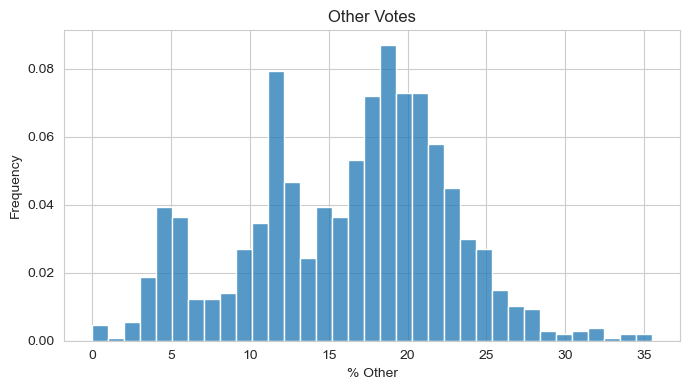

In [85]:
fig, ax = plt.subplots(figsize=(7, 4))

bin_width = 1
max_value = (100 * df.query("state == 'US'")['OTHER']).max()
bins = int(max_value / bin_width)

sns.histplot(100 * df.query("state == 'US'")['OTHER'], bins=bins, stat="probability")
plt.xlabel('% Other')
plt.ylabel('Frequency')
plt.title('Other Votes')

plt.tight_layout()
plt.savefig('weekly_polls.png')
plt.show()

In [86]:
df = df.query("OTHER > 0")
df = df[df['state'].isin(df['state'].value_counts()[df['state'].value_counts() > 10].index)]

In [87]:
df[['DEM', 'GOP', 'OTHER']].describe()

,DEM,GOP,OTHER
count,4146.000000,4146.000000,4146.000000
mean,0.419718,0.398026,0.182256
std,0.077506,0.078810,0.082753
min,0.110400,0.040000,0.010000
25%,0.380000,0.350000,0.120000
50%,0.430000,0.400000,0.166000
75%,0.461475,0.450000,0.230000
max,0.880000,0.632900,0.634800


In [88]:
POLLSTERS = df.query("state == 'US'")['pollster'].sort_values().unique()
POLLSTERS_top = df.query("state == 'US'").groupby('pollster').size().sort_values(ascending=False).head(20).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(20).index.values

POPULATIONS = df.query("state == 'US'")['population'].sort_values().unique()
POPULATIONS_top = df.query("state == 'US'").groupby('population').size().sort_values(ascending=False).head(10).index.values

df = df.reset_index()

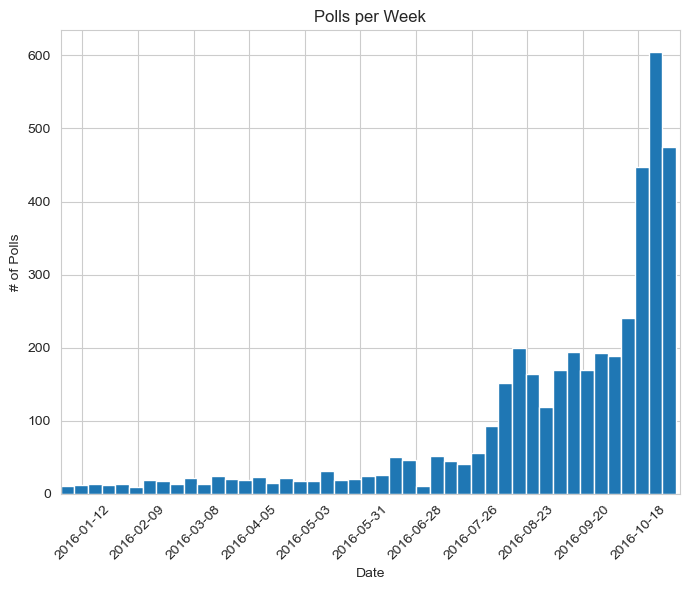

In [89]:
fig, ax = plt.subplots(figsize=(7, 6))

df['date'].hist(bins=len(df['week'].unique()), ax=ax)

ax.set_xlim([election_year, election_date])
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.WeekdayLocator(interval=4))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('# of Polls')
plt.title('Polls per Week')

plt.tight_layout()
plt.show()

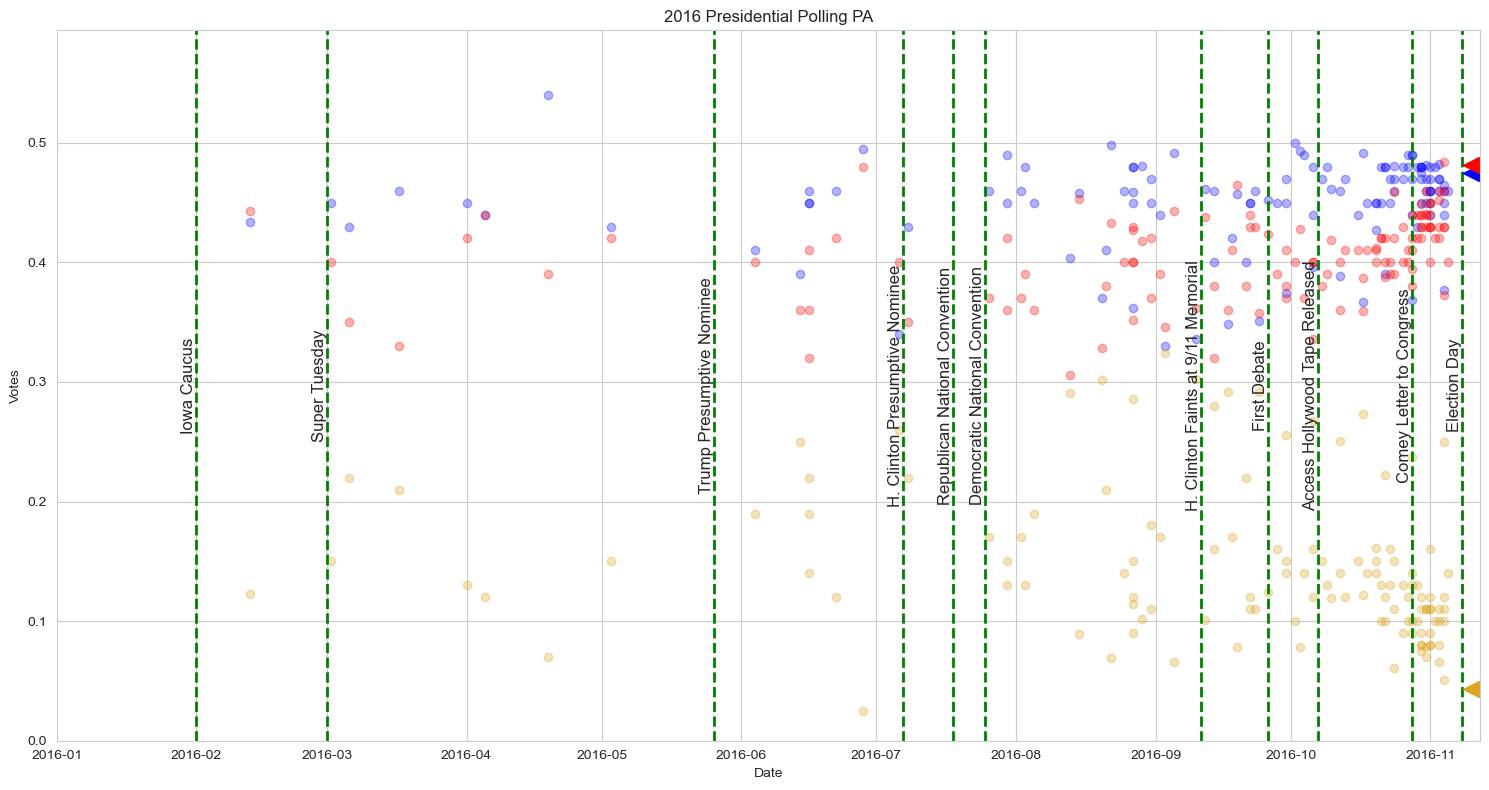

In [105]:
graph_state = 'US'

dem_votes = df.query(f"state == '{graph_state}'")["DEM"].values
gop_votes = df.query(f"state == '{graph_state}'")["GOP"].values
oth_votes = df.query(f"state == '{graph_state}'")["OTHER"].values

dates = df.query(f"state == '{graph_state}'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(dates, dem_votes, "o", alpha=0.3, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.3, color='red', label="Trump")
ax.plot(dates, oth_votes, "o", alpha=0.3, color='goldenrod', label="Other")

ax.set_ylim(0, df.query(f"state == '{graph_state}'")[["DEM", "GOP"]].max().max()*1.1)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title(f'{year} Presidential Polling {graph_state}')

add_event_markers(ax, events, df.query(f"state == '{graph_state}'")[["DEM", "GOP"]].max().max()*1.1/2)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['DEM'], "<", markersize=12, color='blue', alpha=1, label='Actual Margin')
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['GOP'], "<", markersize=12, color='red', alpha=1)
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['OTHER'], "<", markersize=12, color='goldenrod', alpha=1)

plt.tight_layout()
plt.show()

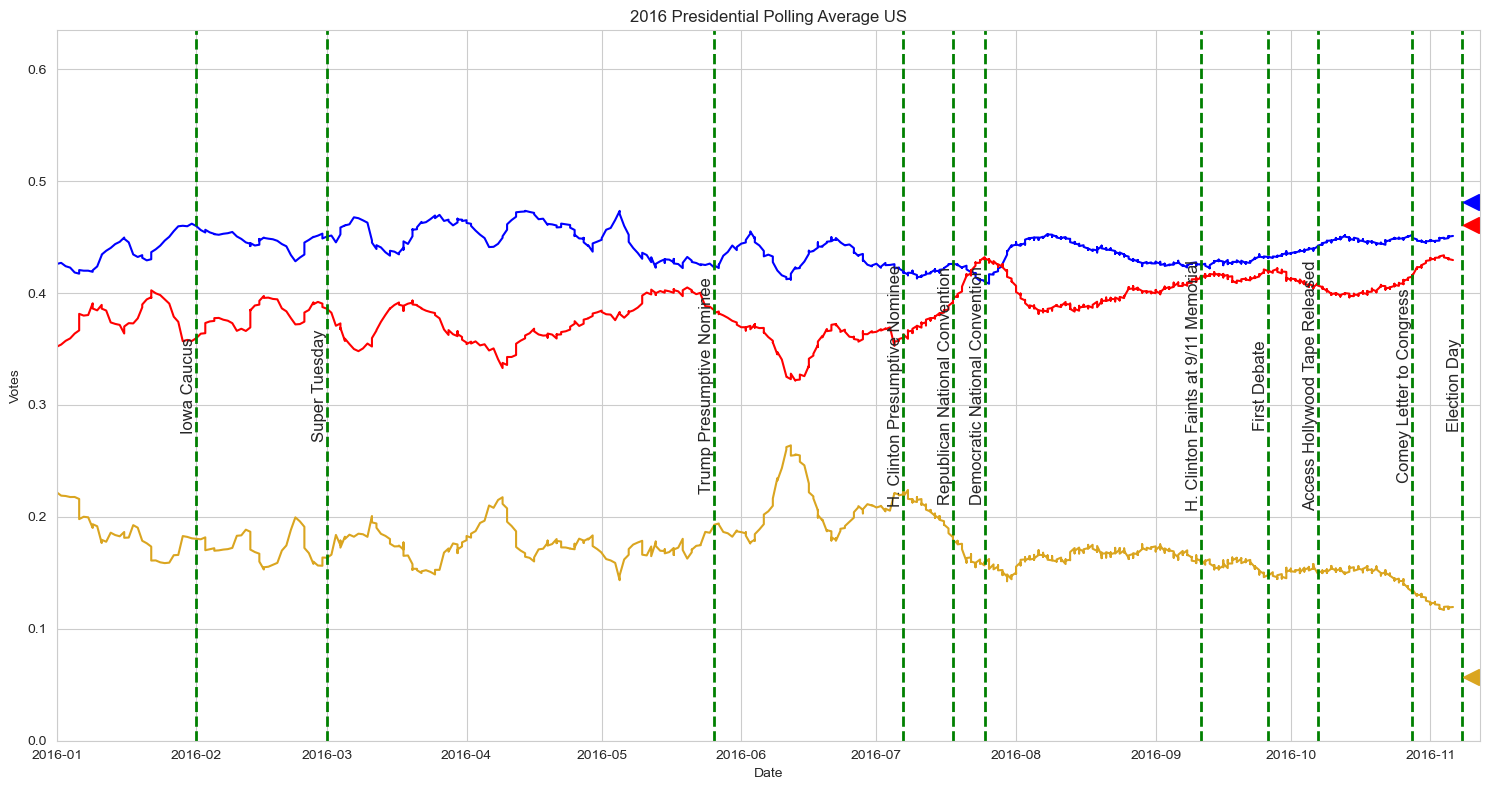

In [109]:
graph_state = 'US'

rolling_mean = (
    df.query(f"state == '{graph_state}'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=1,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=1,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=1,
)

ax.set_ylim(0, df.query(f"state == '{graph_state}'")[["DEM", "GOP"]].max().max()*1.1)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title(f'{year} Presidential Polling Average {graph_state}')

add_event_markers(ax, events, df.query(f"state == '{graph_state}'")[["DEM", "GOP"]].max().max()*1.1/2)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['DEM'], "<", markersize=12, color='blue', alpha=1, label='Actual Margin')
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['GOP'], "<", markersize=12, color='red', alpha=1)
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['OTHER'], "<", markersize=12, color='goldenrod', alpha=1)

plt.tight_layout()
plt.show()

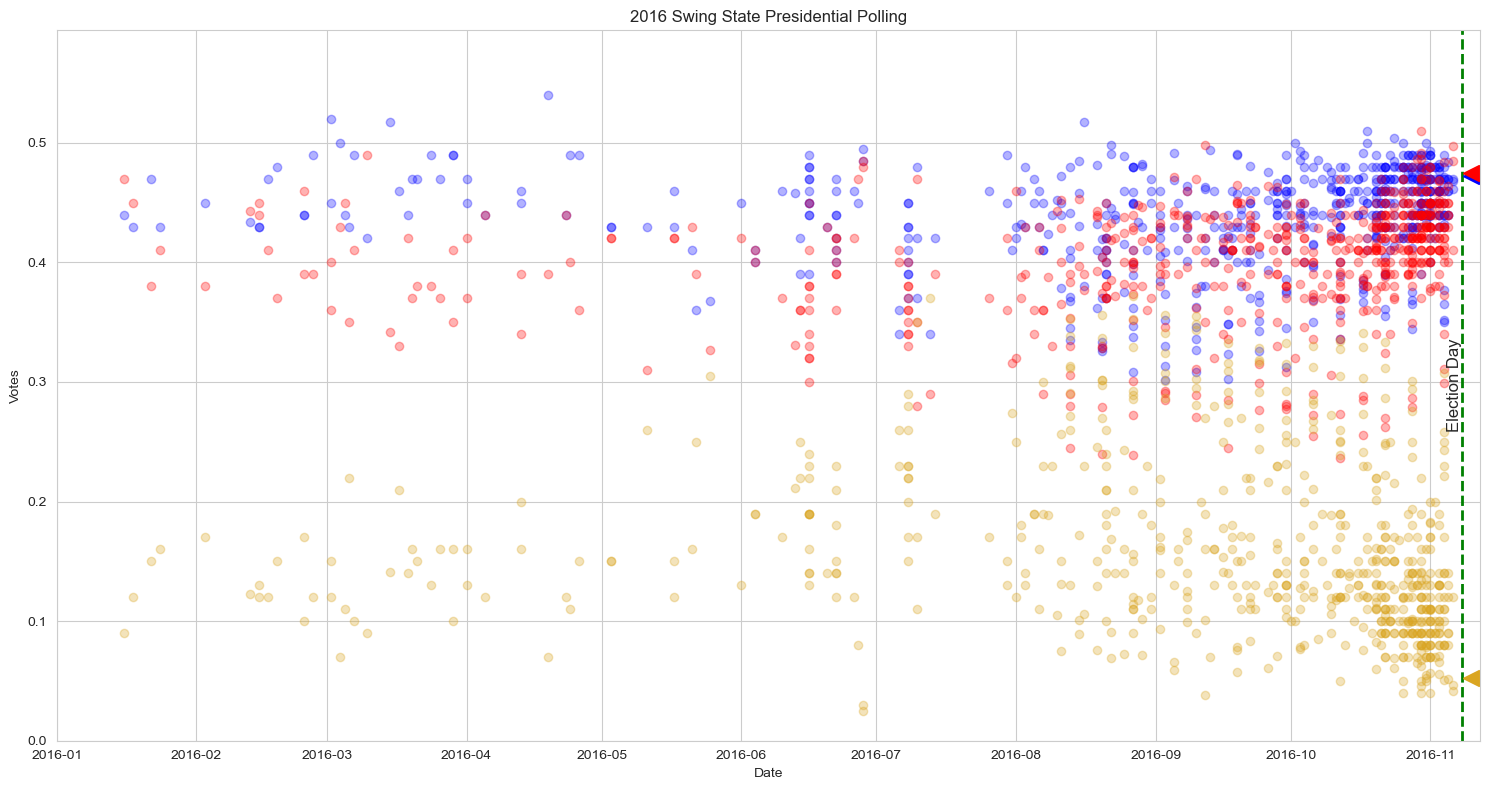

In [92]:
dem_votes = df.query(f"state in {swing_states}")["DEM"].values
gop_votes = df.query(f"state in {swing_states}")["GOP"].values
oth_votes = df.query(f"state in {swing_states}")["OTHER"].values

dates = df.query(f"state in {swing_states}").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(dates, dem_votes, "o", alpha=0.3, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.3, color='red', label="Trump")
ax.plot(dates, oth_votes, "o", alpha=0.3, color='goldenrod', label="Other")

ax.set_ylim(0, df.query(f"state in {swing_states}")[["DEM", "GOP", "OTHER"]].max().max()*1.1)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title(f"{year} Swing State Presidential Polling")

add_event_markers(ax, events, df.query(f"state in {swing_states}")[["DEM", "GOP", "OTHER"]].max().max()*1.1/2)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").DEM.mean(), "<", markersize=12, color='blue', alpha=1, label='Actual Margin')
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").GOP.mean(), "<", markersize=12, color='red', alpha=1)
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").OTHER.mean(), "<", markersize=12, color='goldenrod', alpha=1)

plt.tight_layout()
plt.show()

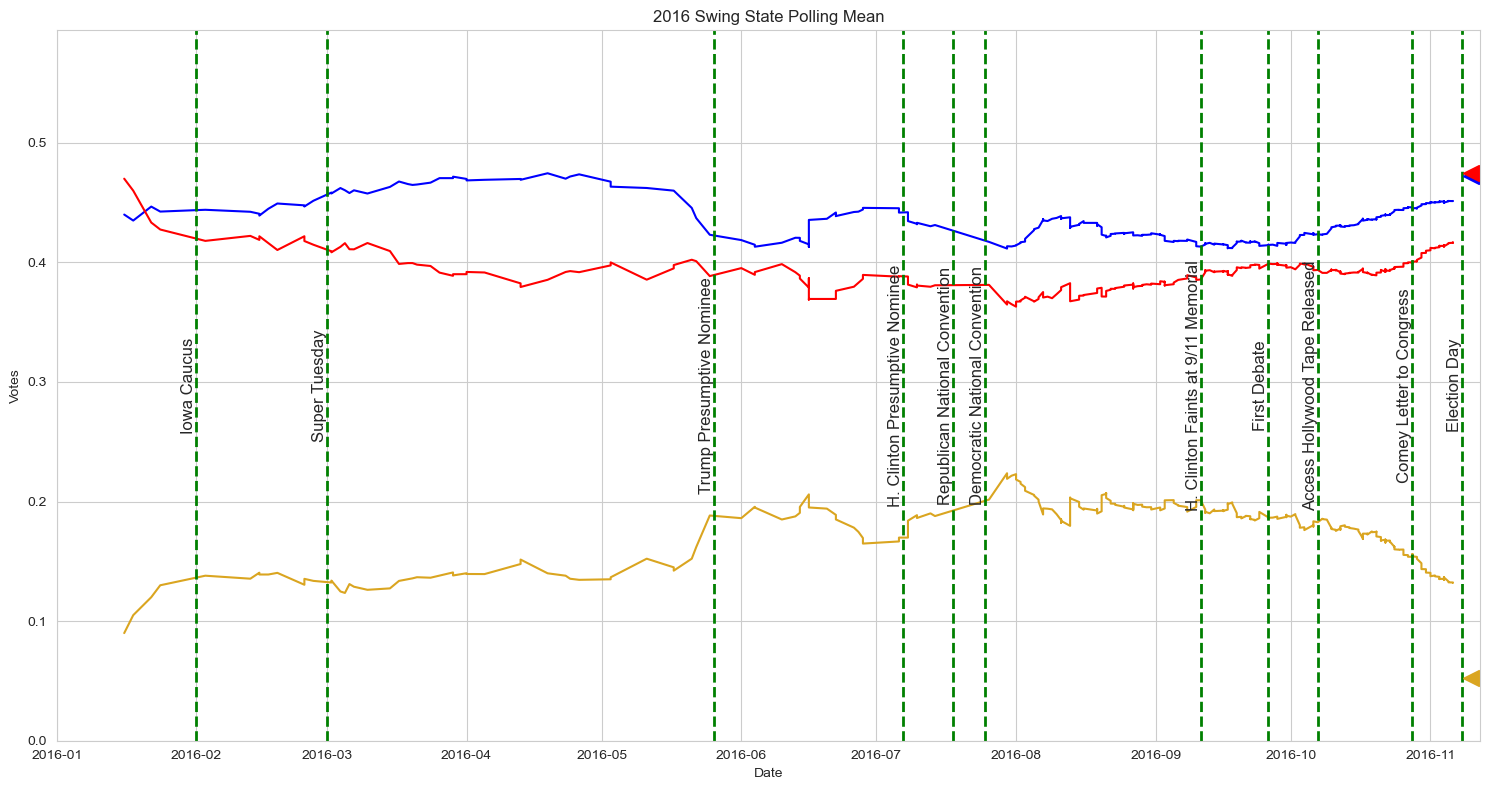

In [111]:
rolling_mean = (
    df.query(f"state in {swing_states}")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()
    .rolling(window='30D')
    .mean()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=1,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=1,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=1,
)

ax.set_ylim(0, df.query(f"state in {swing_states}")[["DEM", "GOP", "OTHER"]].max().max()*1.1)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title(f"{year} Swing State Polling Mean")

add_event_markers(ax, events, df.query(f"state in {swing_states}")[["DEM", "GOP", "OTHER"]].max().max()*1.1/2)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").DEM.mean(), "<", markersize=12, color='blue', alpha=1, label='Actual Margin')
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").GOP.mean(), "<", markersize=12, color='red', alpha=1)
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").OTHER.mean(), "<", markersize=12, color='goldenrod', alpha=1)

plt.tight_layout()
plt.show()

In [94]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

x_res = np.maximum(df.query("state == 'US'").margin.quantile(q=1), df.query("state == 'US'").margin.quantile(q=0) * -1)

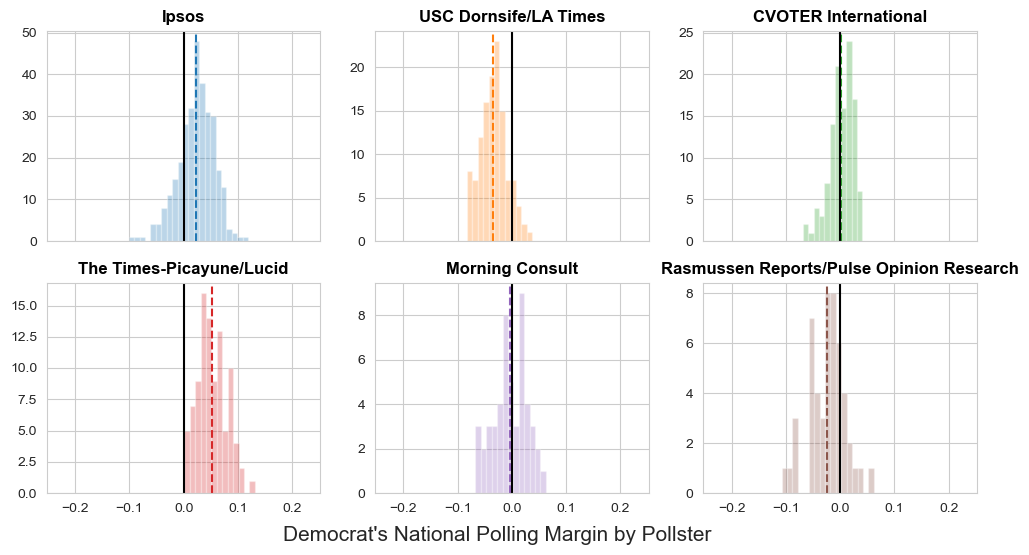

In [27]:
POLLSTER_VALS = {
    pollster: df.query("state == 'US'")[df.query("state == 'US'")["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

colors = plt.rcParams["axes.prop_cycle"]()

fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(12, 6))

for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.axvline(x=0, color="black")
    ax.set_xlim(-x_res, x_res)
    
    ax.text(0.5, 1.1, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
fig.text(0.5, 0.03, r"Democrat's National Polling Margin by Pollster", ha='center', fontsize=15)

plt.show()

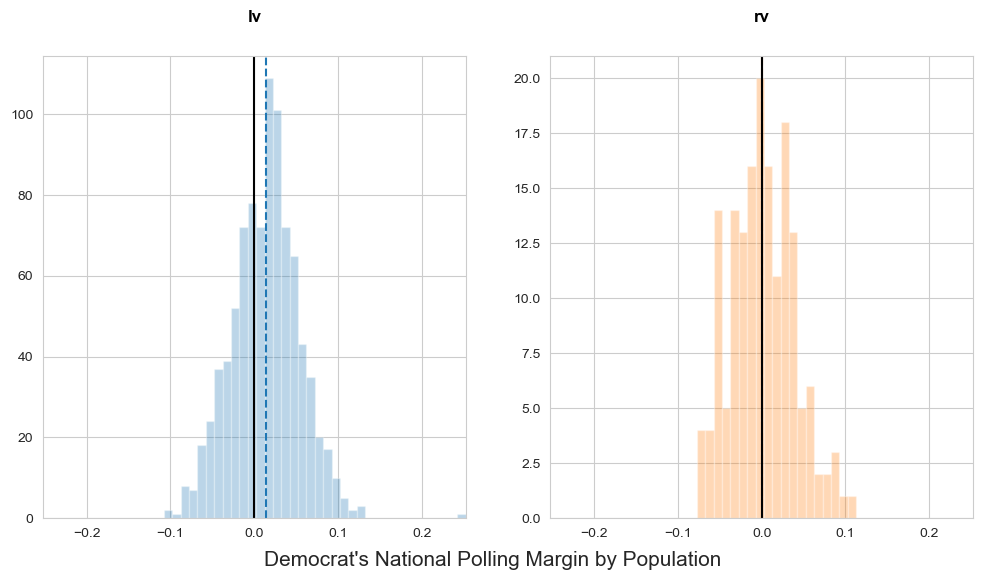

In [28]:
POPULATIONS_VALS = {
    population: df.query("state == 'US'")[df.query("state == 'US'")["population"] == population]["diff_margin"].values
    for population in list(POPULATIONS_top)
}

colors = plt.rcParams["axes.prop_cycle"]()

fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(12, 6))

for ax, (pollster, vals) in zip(axes.ravel(), POPULATIONS_VALS.items()):
    c = next(colors)["color"]
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.axvline(x=0, color="black")
    ax.set_xlim(-x_res, x_res)
    
    ax.text(0.5, 1.1, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
fig.text(0.5, 0.03, r"Democrat's National Polling Margin by Population", ha='center', fontsize=15)

plt.show()

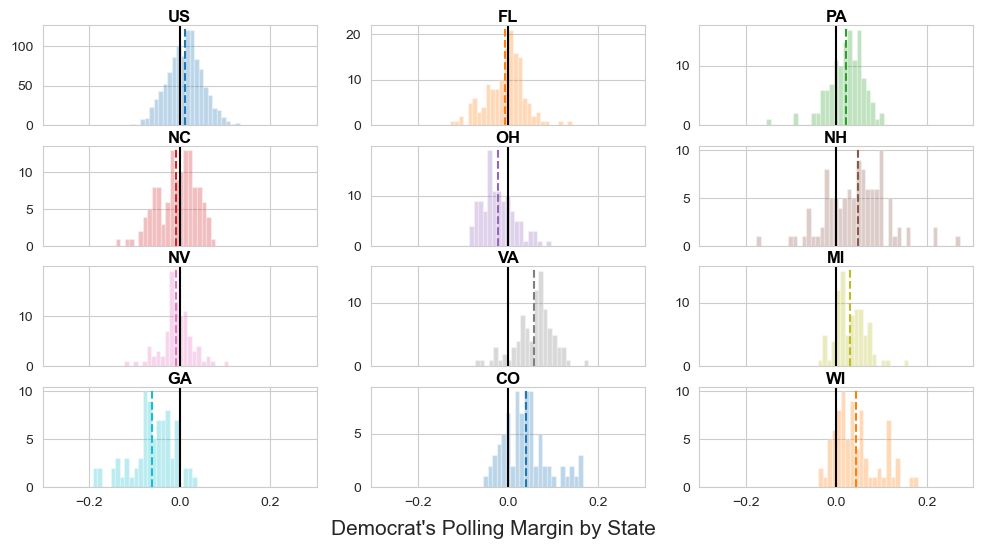

In [29]:
STATE_VALS = {
    state: df[df["state"] == state]["diff_margin"].values
    for state in list(STATES_top)
}

colors = plt.rcParams["axes.prop_cycle"]()

fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(12, 6))

for ax, (pollster, vals) in zip(axes.ravel(), STATE_VALS.items()):
    c = next(colors)["color"]
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.axvline(x=0, color="black")
    ax.set_xlim(-x_res*1.2, x_res*1.2)
    
    ax.text(0.5, 1.15, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
fig.text(0.5, 0.03, r"Democrat's Polling Margin by State", ha='center', fontsize=15)

plt.show()

In [30]:
date_counts = df['date'].value_counts().reset_index()
date_counts.columns = ['date', 'count']
date_counts = date_counts.sort_values(by='date', ascending=False).reset_index(drop=True)

In [31]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

day_id = df.day.to_numpy()
day = np.arange(df.day.min(), 1)

party_id, party = [0,1,2], ['DEM','GOP','Other']

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [32]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6

    dem_sigma       = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_rho         = pm.Normal("dem_rho", mu=0, sigma=0.7)
    dem_ar          = pm.AR("dem_ar",
                            rho=[dem_rho] * 7,
                            sigma=dem_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    dem_sigma_rw    = pm.HalfNormal("dem_sigma_rw", sigma=0.1) + epsilon
    dem_random_walk = pm.GaussianRandomWalk("dem_random_walk",
                                            sigma=dem_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    dem_day_effect  = pm.Deterministic("dem_day_effect", dem_ar + dem_random_walk, dims="day")

    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.5, dims="pollster")
    dem_state_effect    = pm.Normal("dem_state_effect", 0, 0.5, dims="state")
    dem_state_multi     = pm.Normal("dem_state_multi", 1, 0.5, dims="state")
    dem_pop_effect      = pm.Normal("dem_pop_effect", 0, 0.5, dims="population")

    dem_polling = pm.Deterministic("dem_polling", pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    ),
        dims = "observation")
    
    gop_sigma       = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_rho         = pm.Normal("gop_rho", mu=0, sigma=0.7)
    gop_ar          = pm.AR("gop_ar",
                            rho=[gop_rho] * 7,
                            sigma=gop_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    gop_sigma_rw    = pm.HalfNormal("gop_sigma_rw", sigma=0.1) + epsilon
    gop_random_walk = pm.GaussianRandomWalk("gop_random_walk",
                                            sigma=gop_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    gop_day_effect  = pm.Deterministic("gop_day_effect", gop_ar + gop_random_walk, dims="day")

    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.5, dims="pollster")
    gop_state_effect    = pm.Normal("gop_state_effect", 0, 0.5, dims="state")
    gop_state_multi     = pm.Normal("gop_state_multi", 1, 0.5, dims="state")
    gop_pop_effect      = pm.Normal("gop_pop_effect", 0, 0.5, dims="population")

    gop_polling = pm.Deterministic("gop_polling", pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_pop_effect[population_id] +
        gop_state_effect[state_id] +
        gop_state_multi[state_id] *
        gop_day_effect[day_id]
    ),
        dims = "observation")

    oth_sigma       = pm.HalfNormal("oth_sigma", sigma=0.1) + epsilon
    oth_rho         = pm.Normal("oth_rho", mu=0, sigma=0.7)
    oth_ar          = pm.AR("oth_ar",
                            rho=[oth_rho] * 7,
                            sigma=oth_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    oth_sigma_rw    = pm.HalfNormal("oth_sigma_rw", sigma=0.1) + epsilon
    oth_random_walk = pm.GaussianRandomWalk("oth_random_walk",
                                            sigma=oth_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    oth_day_effect  = pm.Deterministic("oth_day_effect", oth_ar + oth_random_walk, dims="day")

    oth_pollster_effect = pm.Normal("oth_pollster_effect", 0, 0.5, dims="pollster")
    oth_state_effect    = pm.Normal("oth_state_effect", 0, 0.5, dims="state")
    oth_state_multi     = pm.Normal("oth_state_multi", 1, 0.5, dims="state")
    oth_pop_effect      = pm.Normal("oth_pop_effect", 0, 0.5, dims="population")

    oth_polling = pm.Deterministic("oth_polling", pm.math.invlogit(
        oth_pollster_effect[pollster_id] +
        oth_pop_effect[population_id] +
        oth_state_effect[state_id] +
        oth_state_multi[state_id] *
        oth_day_effect[day_id]
    ),
        dims = "observation")

    dem_vote = pm.Binomial(
        "dem_vote",
        p = dem_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['DEM'],
        dims = "observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p = gop_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['GOP'],
        dims = "observation",
    )

    oth_vote = pm.Binomial(
        "oth_vote",
        p = oth_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['OTHER'],
        dims = "observation",
    )

    polling_error_state_dem = pm.Normal("polling_error_state_dem", 0, 1, dims="state")
    polling_error_state_gop = pm.Deterministic("polling_error_state_gop", -polling_error_state_dem, dims="state")
    polling_error_state_oth = pm.Deterministic("polling_error_state_oth", polling_error_state_dem*0, dims="state")

    idata = pm.sample(draws=1000, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_rho, dem_ar, dem_sigma_rw, dem_random_walk, dem_pollster_effect, dem_state_effect, dem_state_multi, dem_pop_effect, gop_sigma, gop_rho, gop_ar, gop_sigma_rw, gop_random_walk, gop_pollster_effect, gop_state_effect, gop_state_multi, gop_pop_effect, oth_sigma, oth_rho, oth_ar, oth_sigma_rw, oth_random_walk, oth_pollster_effect, oth_state_effect, oth_state_multi, oth_pop_effect, polling_error_state_dem]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 3851 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [35]:
states = df['state'].unique()
parties = ['dem','gop','margin','oth']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

interim = pd.DataFrame()

for party in ['dem', 'gop', 'oth']:
    pollster_effects = best_pollsters(party, idata)
    pollster_effects_flat = pollster_effects.ravel()
    interim[f"pollster_effects_{party}"] = pollster_effects_flat

    pop_effects = (
        idata.posterior[f"{party}_pop_effect"].sel(population="lv")
    ).values
    pop_effects_flat = pop_effects.ravel()
    interim[f"pop_effects_{party}"] = pop_effects_flat

    interim[f"fund_{party}"] = interim[f"pollster_effects_{party}"] +  interim[f"pop_effects_{party}"]

In [36]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

#for d in [-8]:
for d in tqdm(day):
    day_results = {}
    for state in states:
        for party in ['dem', 'gop', 'oth']:
            polling_error = 0.03 * idata.posterior[f"polling_error_state_{party}"].sel(state=f"{state}").values.ravel() if state == 'US' else 0.067 * idata.posterior[f"polling_error_state_{party}"].sel(state=f"{state}").values.ravel()
            day_results[f"{state}_{party}"] = inv_logit(
                interim[f"fund_{party}"] +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}").values.ravel() +
                polling_error +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}").values.ravel() *
                (idata.posterior[f"{party}_day_effect"].sel(day=d).values.ravel()
                #+ (.1 if party == 'gop' else 0) # 2% swing towards GOP
                #+ (.05 if party == 'dem' else 0) # 1% swing towards DEM
                )  
            ).to_numpy()

        total = sum(day_results[f"{state}_{party}"] for party in ['dem', 'gop', 'oth'])
        for party in ['dem', 'gop', 'oth']:
            day_results[f"{state}_{party}"] /= total
        
        day_results[f"{state}_margin"] = day_results[f"{state}_dem"] - day_results[f"{state}_gop"]

    df_results = pd.DataFrame(day_results)

    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_mean.loc[d] = df_results.quantile(0.50)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 313/313 [01:09<00:00,  4.49it/s]


In [37]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end=election_date)
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')

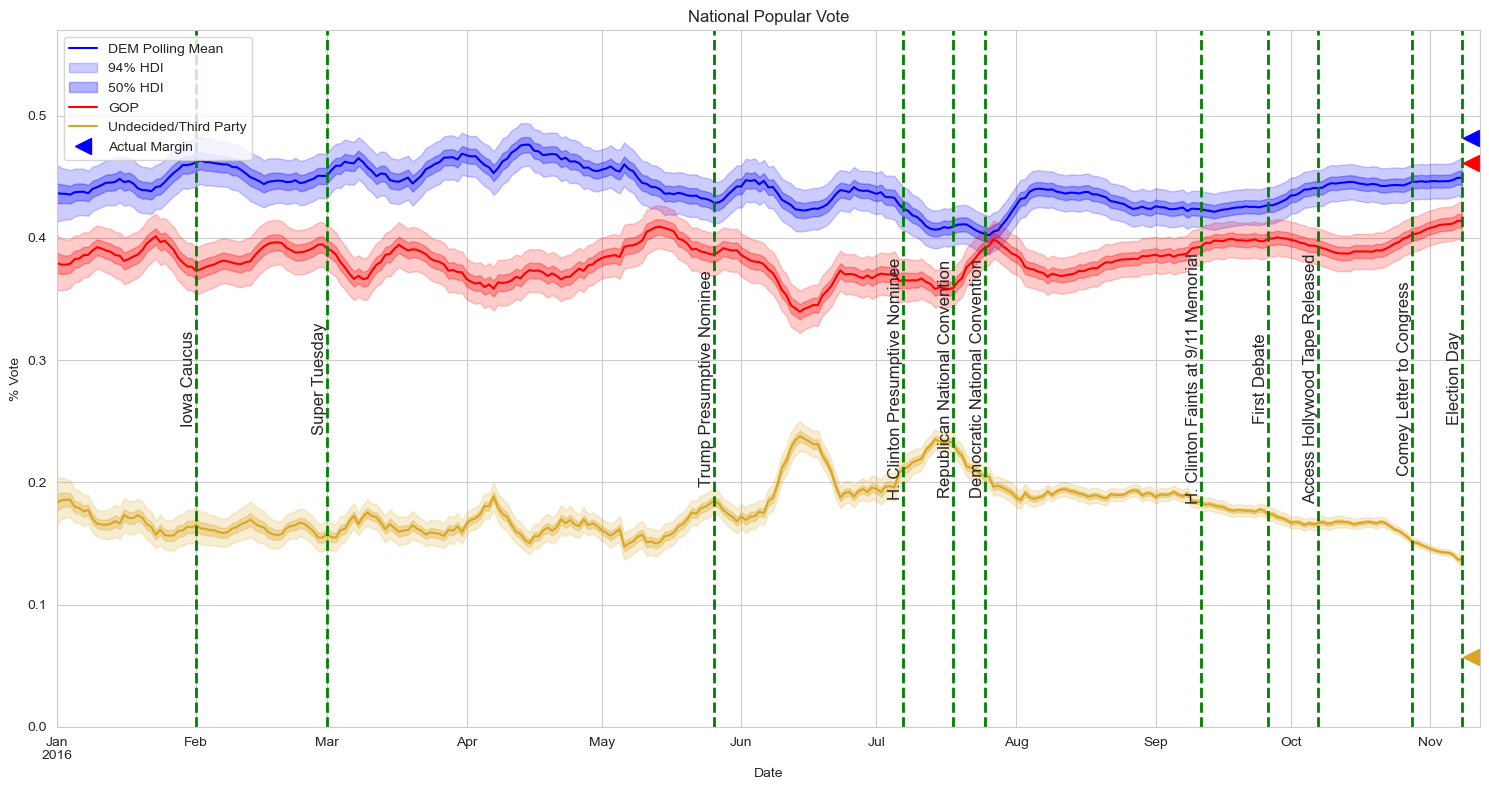

In [114]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(15, 8))

df_day_mean[f"{graph_state}_dem"].rolling(window='7D').mean().plot(color='blue', label='DEM Polling Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), color='blue', alpha=0.2, label='94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), color='blue', alpha=0.3, label='50% HDI')

df_day_mean[f"{graph_state}_gop"].rolling(window='7D').mean().plot(color='red', label='GOP')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), color='red', alpha=0.2)
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), color='red', alpha=0.3)

df_day_mean[f"{graph_state}_oth"].rolling(window='7D').mean().plot(color='goldenrod', label='Undecided/Third Party')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), color='goldenrod', alpha=0.2)
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), color='goldenrod', alpha=0.3)

ax.set_ylim(0,df_day_97[[f"{graph_state}_dem", f"{graph_state}_gop", f"{graph_state}_oth"]].max().max()*1.1)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.set_title('National Popular Vote')

add_event_markers(ax, events, df_day_97[[f"{graph_state}_dem", f"{graph_state}_gop", f"{graph_state}_oth"]].max().max()*1.1/2)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['DEM'], "<", markersize=12, color='blue', alpha=1, label='Actual Margin')
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['GOP'], "<", markersize=12, color='red', alpha=1)
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['OTHER'], "<", markersize=12, color='goldenrod', alpha=1)

ax.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/popular_vote.png')

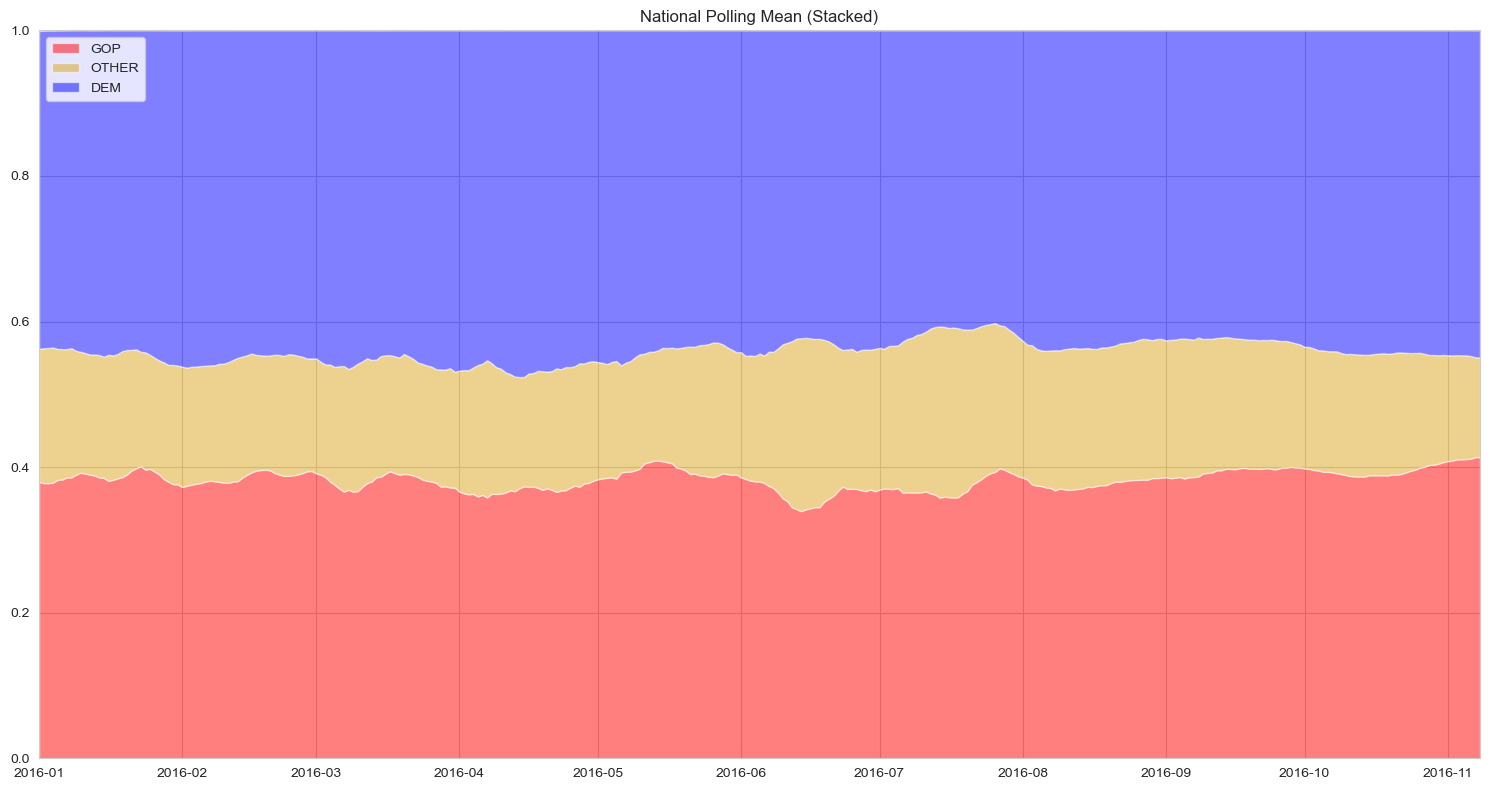

In [39]:
graph_state = 'US'

rolling_mean = (
    df_day_mean[[f"{graph_state}_gop", f"{graph_state}_oth", f"{graph_state}_dem"]]
    .sort_index()
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", f"{graph_state}_gop", f"{graph_state}_oth", f"{graph_state}_dem"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(15, 8))

ax.stackplot(
    rolling_mean.date,
    rolling_mean[f"{graph_state}_gop"].values,
    rolling_mean[f"{graph_state}_oth"].values,
    rolling_mean[f"{graph_state}_dem"].values,
    labels=["GOP", "OTHER", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=.5,
)

ax.set_ylim(0, 1)
ax.set_xlim([election_year, election_date])
ax.set_title("National Polling Mean (Stacked)")
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/stacked.png')

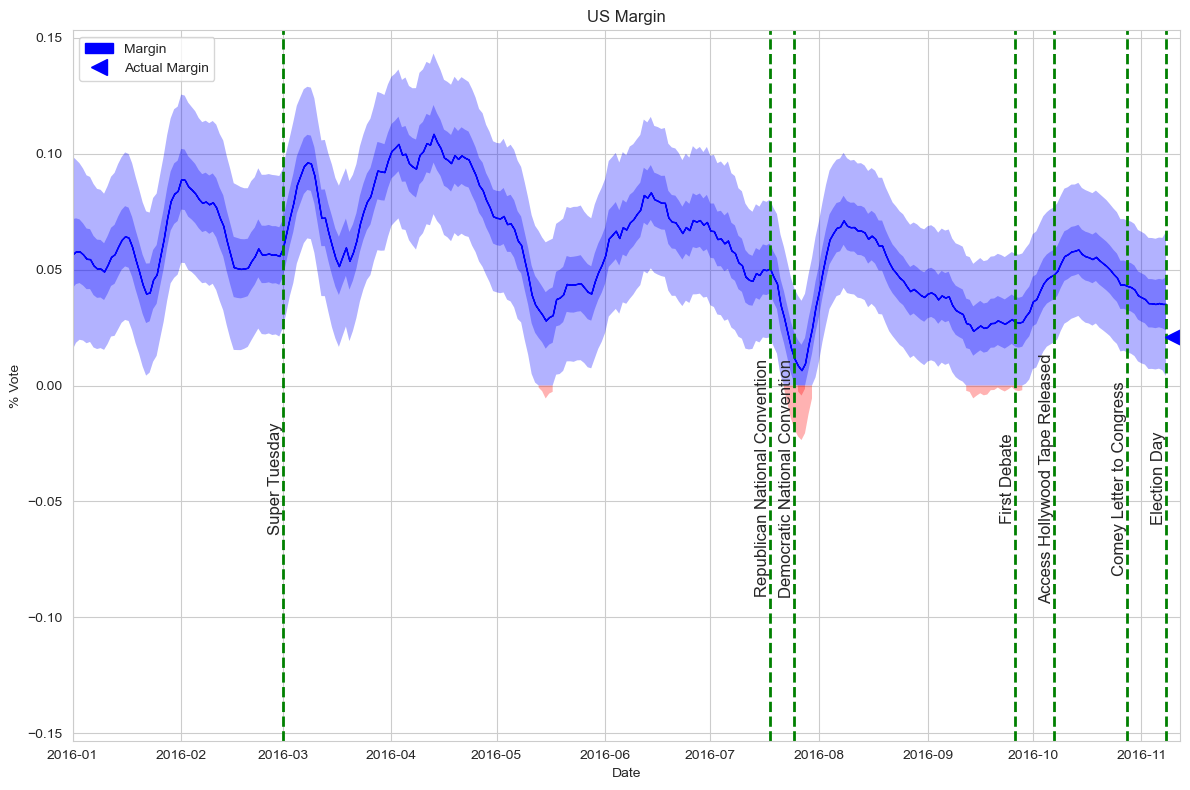

In [113]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(12, 8))

mean_rolling = df_day_mean[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_03_rolling = df_day_03[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_97_rolling = df_day_97[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_25_rolling = df_day_25[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_75_rolling = df_day_75[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_03_rolling), 
                 np.maximum(hdi_97_rolling,0),
                 where=hdi_97_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_25_rolling), 
                 np.maximum(hdi_75_rolling,0), 
                 where=hdi_75_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,mean_rolling), 
                 np.maximum(mean_rolling,0), 
                 where=mean_rolling > 0, 
                 color='blue', alpha=1, label='Margin')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_03_rolling), 
                 np.minimum(hdi_97_rolling,0),
                 where=hdi_03_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_25_rolling), 
                 np.minimum(hdi_75_rolling,0), 
                 where=hdi_25_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,mean_rolling), 
                 np.minimum(mean_rolling,0), 
                 where=mean_rolling < 0, 
                 color='red', alpha=1)

y_res = np.maximum((min(hdi_03_rolling)-.01)*-1, max(hdi_97_rolling)+.01)
ax.set_ylim(-y_res, y_res)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])

ax.set_title(f'{graph_state} Margin')
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')

add_event_markers(ax, events_sig, -.04)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['margin'], "<", markersize=12, color='blue', alpha=1, label='Actual Margin')

ax.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/popular_vote_margin.png')

In [41]:
state_loop = swing_states

for state in state_loop:
    graph_state = state
    
    plt.figure(figsize=(10, 6))
    
    bin_edges = np.arange(-0.3, 0.31, 0.01)
    
    ax = sns.histplot(df_results[f"{graph_state}_margin"], bins=bin_edges, kde=False, stat="probability")
    
    for patch in ax.patches:
        x = patch.get_x() + 0.5 * patch.get_width()
        
        if x < 0:
            patch.set_facecolor('red')
        elif x > 0:
            patch.set_facecolor('blue')
        elif x == 0:
            patch.set_facecolor('lime')
    
    plt.title(f'{year} - {state} Margin')
    plt.xlabel('Democratic Margin')
    plt.xlim(-0.3, 0.3)
    plt.ylabel('Probability')
        
    plt.tight_layout()
    plt.savefig(f'../Results/{year}_president/margin_{state.lower()}.png')

    plt.close()

In [50]:
df_winner = pd.DataFrame(columns=states)

for state in states:

    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [51]:
df_state['state_code'][~df_state['state_code'].isin(df_winner.columns)]

31    NE-1
32    NE-2
33    NE-3
Name: state_code, dtype: object

In [52]:
missing_states(df_winner)

state_order = df_state['state_code'].to_list

In [53]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [54]:
df_ec = pd.DataFrame()
df_ec['dem'] = df_winner_dem.mul(df_state[['state_code', f'electoral_{year}']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['gop'] = df_winner_gop.mul(df_state[['state_code', f'electoral_{year}']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['dem_pop'] = df_winner_dem['US']
df_ec['gop_pop'] = df_winner_gop['US']
df_ec['dem_ec'] = np.where(df_ec['dem'] >= 270, 1, 0)
df_ec['gop_ec'] = np.where(df_ec['gop'] >= 270, 1, 0)
df_ec['tie_ec'] = np.where(df_ec['dem'] == 269, 1, 0)

In [55]:
total_rows = len(df_ec)

greater_than_270 = len(df_ec[df_ec['dem'] > 269])
equal_to_270 = len(df_ec[df_ec['dem'] == 269])
lower_than_270 = len(df_ec[df_ec['dem'] < 269])

percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(81.08999999999999, 0.5700000000000001, 18.34)

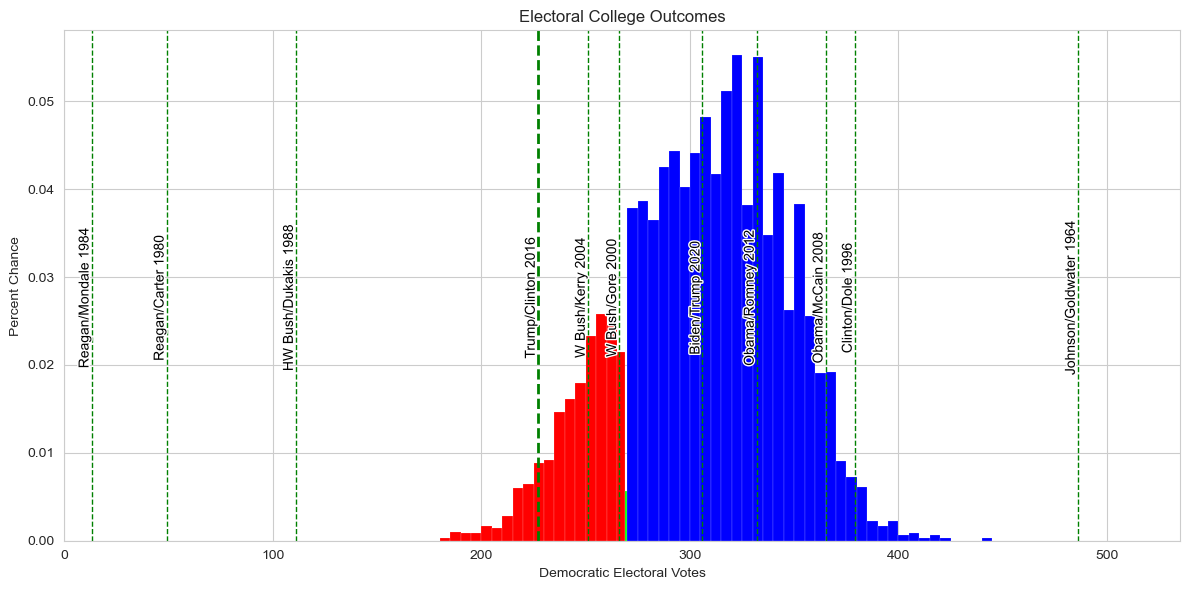

In [56]:
plt.figure(figsize=(12, 6))

bins = list(range(0, 269, 5)) + [269] + list(range(270, 540, 5))

ax = sns.histplot(df_ec['dem'], bins=bins, kde=False, stat="probability")

max_height = max([patch.get_height() for patch in ax.patches])
lowest_bar = min([patch.get_x() for patch in ax.patches])
highest_bar = max([patch.get_x() + patch.get_width() for patch in ax.patches])

for patch in ax.patches:
    x = patch.get_x()
    
    if x < 269:
        patch.set_facecolor('red')
    elif x > 269:
        patch.set_facecolor('blue')
    elif x == 269:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('lime')

plt.title('Electoral College Outcomes')
plt.xlabel('Democratic Electoral Votes')
plt.xlim(lowest_bar, highest_bar)
plt.ylabel('Percent Chance')

events = [
    (13, 'Reagan/Mondale 1984'),
    (49, 'Reagan/Carter 1980'),
    (111, 'HW Bush/Dukakis 1988'),
    (227, 'Trump/Clinton 2016'),
    (251, 'W Bush/Kerry 2004'),
    (266, 'W Bush/Gore 2000'),
    (306, 'Biden/Trump 2020'),
    (332, 'Obama/Romney 2012'),
    (365, 'Obama/McCain 2008'),
    (379, 'Clinton/Dole 1996'),
    (486, 'Johnson/Goldwater 1964')
]

label_position = 1/2 * max_height

for date, event in events:
        if str(year) in event:
            color = 'green'
            linewidth = 2
        else:
            color = 'green'
            linewidth = 1
        ax.axvline(x=date, color=color, linestyle='--', linewidth=linewidth)
        text = ax.text(date, label_position, event, rotation=90, verticalalignment='center', 
                       horizontalalignment='right', fontsize=10, color='black')
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ])

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/electoral_vote_margin.png')

In [57]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)
df_oth = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['margin'] = df_margin.mean()

In [58]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [59]:
print("Safe D: ")
print(df_win_pct.query("dem >= .98").index.sort_values().values)
print("Likely D: ")
print(df_win_pct.query("(dem < .98) and (dem >= .75)").index.sort_values().values)
print("Leans D: ")
print(df_win_pct.query("(dem < .75) and (dem >= .6)").index.sort_values().values)
print("Tilt D: ")
print(df_win_pct.query("(dem < .6) and (dem >= .5)").index.sort_values().values)
print("Tilt R: ")
print(df_win_pct.query("(gop < .6) and (gop >= .5)").index.sort_values().values)
print("Leans R: ")
print(df_win_pct.query("(gop < .75) and (gop >= .6)").index.sort_values().values)
print("Likely R: ")
print(df_win_pct.query("(gop < .98) and (gop >= .75)").index.sort_values().values)
print("Safe R: ")
print(df_win_pct.query("gop >= .98").index.sort_values().values)

Safe D: 
['CA' 'CT' 'DC' 'DE' 'HI' 'IL' 'MA' 'MD' 'ME-1' 'NJ' 'NY' 'OR' 'RI' 'VT'
 'WA']
Likely D: 
['CO' 'ME' 'MN' 'NH' 'NM' 'PA' 'US' 'VA' 'WI']
Leans D: 
['MI' 'NC']
Tilt D: 
['FL' 'NV']
Tilt R: 
[]
Leans R: 
['AZ' 'ME-2' 'OH']
Likely R: 
['AK' 'GA' 'IA' 'SC' 'UT']
Safe R: 
['AL' 'AR' 'ID' 'IN' 'KS' 'KY' 'LA' 'MO' 'MS' 'MT' 'ND' 'NE' 'NE-1' 'NE-2'
 'NE-3' 'OK' 'SD' 'TN' 'TX' 'WV' 'WY']


In [60]:
pct_dem_wo_pop = 100*len(df_ec.query("(gop_pop == 1) & (dem > 269)"))/len(df_ec)
pct_gop_wo_pop = 100*len(df_ec.query("(dem_pop == 1) & (gop > 269)"))/len(df_ec)

print("% Chance of a Win in Electoral College")
print("--------------------------------------")
print(" Democrats:   " + f"{round(percent_greater_than_270,2):6.2f}" + "%")
print(" Tie:         " + f"{round(percent_equal_to_270,2):6.2f}" + "%")
print(" Republicans: " + f"{round(percent_lower_than_270,2):6.2f}" + "%")
print()
print("Electoral College Estimates")
print("---------------------------")
print("  %  |  DEM  |  GOP  | Margin ")
print("  3% |  "+ f"{df_ec.dem.quantile(0.03):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.97):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.03) - df_ec.gop.quantile(0.97), 2):4.0f}")
print(" 25% |  "+ f"{df_ec.dem.quantile(0.25):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.75):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.25) - df_ec.gop.quantile(0.75), 2):4.0f}")
print(" 50% |  "+ f"{df_ec.dem.quantile(0.50):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.50):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.50) - df_ec.gop.quantile(0.50), 2):4.0f}")
print(" 75% |  "+ f"{df_ec.dem.quantile(0.75):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.25):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.75) - df_ec.gop.quantile(0.25), 2):4.0f}")
print(" 97% |  "+ f"{df_ec.dem.quantile(0.97):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.03):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.97) - df_ec.gop.quantile(0.03), 2):4.0f}")
print()
print("% Chance of Popular Vote Win")
print("----------------------------")
print(" Democrats:   " + f"{round(df_winner_dem.US.mean()*100,2):6.2f}" + "%")
print(" Republicans: " + f"{round(df_winner_gop.US.mean()*100,2):6.2f}" + "%")
print()
print("% Chance of a Win without Popular Vote")
print("--------------------------------------")
print(" Democrats:   " + f"{round(pct_dem_wo_pop,2):6.2f}" + "%")
print(" Republicans: " + f"{round(pct_gop_wo_pop,2):6.2f}" + "%")
print(" Total:       " + f"{round(pct_dem_wo_pop+pct_gop_wo_pop,2):6.2f}" + "%")
print()
print("Popular Vote Estimates")
print("----------------------")
print("  %  |  DEM  |  GOP  | Margin ")
print("  3% | "+ f"{df_dem.US.quantile(0.03) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.97) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.03) * 100 - df_gop.US.quantile(0.97) * 100, 2):6.2f}")
print(" 25% | "+ f"{df_dem.US.quantile(0.25) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.75) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.25) * 100 - df_gop.US.quantile(0.75) * 100, 2):6.2f}")
print(" 50% | "+ f"{df_dem.US.quantile(0.50) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.50) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.50) * 100 - df_gop.US.quantile(0.50) * 100, 2):6.2f}")
print(" 75% | "+ f"{df_dem.US.quantile(0.75) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.25) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.75) * 100 - df_gop.US.quantile(0.25) * 100, 2):6.2f}")
print(" 97% | "+ f"{df_dem.US.quantile(0.97) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.03) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.97) * 100 - df_gop.US.quantile(0.03) * 100, 2):6.2f}")

% Chance of a Win in Electoral College
--------------------------------------
 Democrats:    81.09%
 Tie:           0.57%
 Republicans:  18.34%

Electoral College Estimates
---------------------------
  %  |  DEM  |  GOP  | Margin 
  3% |  229  |  309  |   -80
 25% |  278  |  260  |    18
 50% |  307  |  231  |    76
 75% |  334  |  204  |   130
 97% |  371  |  167  |   204

% Chance of Popular Vote Win
----------------------------
 Democrats:    91.95%
 Republicans:   8.05%

% Chance of a Win without Popular Vote
--------------------------------------
 Democrats:     2.66%
 Republicans:  13.04%
 Total:        15.70%

Popular Vote Estimates
----------------------
  %  |  DEM  |  GOP  | Margin 
  3% | 42.03 | 44.24 | -2.21
 25% | 43.83 | 42.41 |  1.42
 50% | 44.84 | 41.40 |  3.44
 75% | 45.86 | 40.39 |  5.47
 97% | 47.70 | 38.62 |  9.08


In [61]:
margin_and_ec = pd.DataFrame()
margin_and_ec['pop'] = df_results.US_margin
margin_and_ec['ec'] = df_ec.dem - df_ec.gop

margin_and_ec = margin_and_ec.groupby('ec').agg(
    count=('pop', 'size'),
    pop=('pop', 'mean')
).reset_index().sort_values("count", ascending = False)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/1609655890.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/1609655890.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


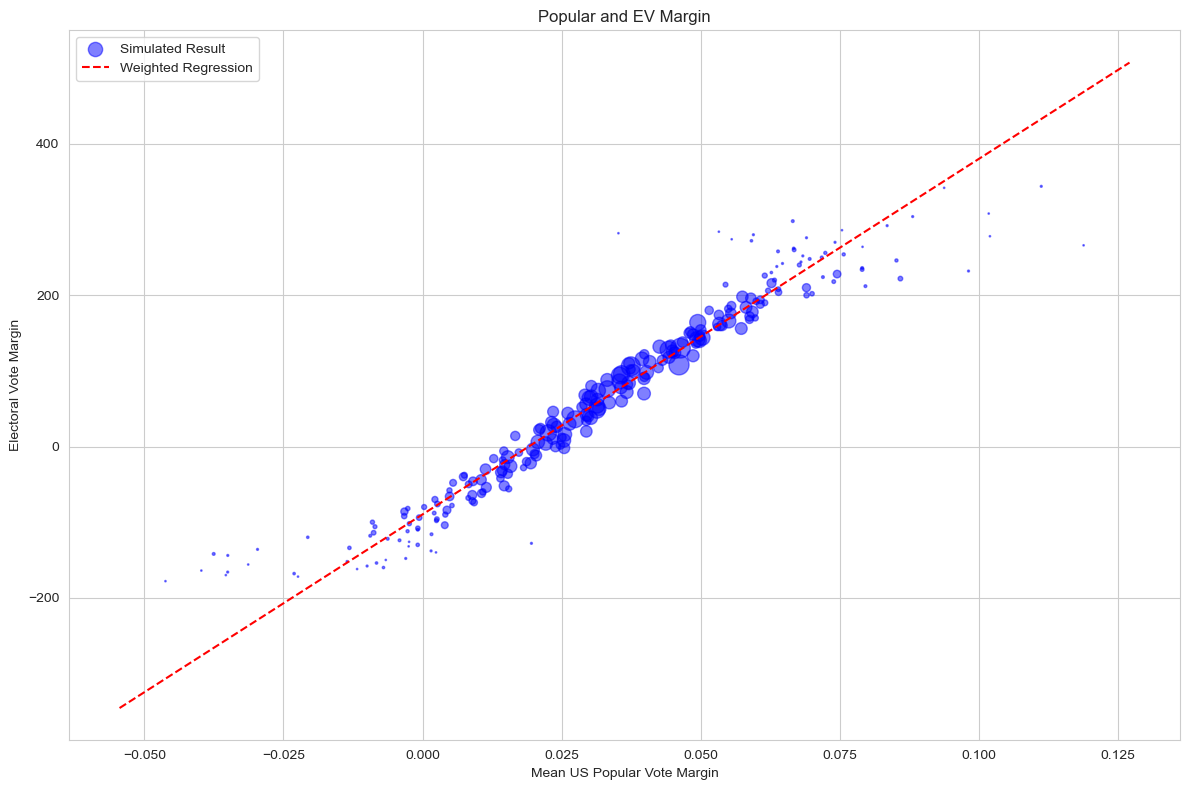

In [62]:
plt.figure(figsize=(12, 8))

plt.scatter(margin_and_ec['pop'], margin_and_ec['ec'], 
            s=margin_and_ec['count'], color='blue', alpha=0.5, label='Simulated Result')

X = margin_and_ec['pop']
y = margin_and_ec['ec']
weights = margin_and_ec['count']

X = sm.add_constant(X)

wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

slope = results.params[1]
intercept = results.params[0]

x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

plt.xlabel('Mean US Popular Vote Margin')
plt.ylabel('Electoral Vote Margin')
plt.title('Popular and EV Margin')

plt.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/electoral_college_adv.png')

In [63]:
print("Electoral College Advantage: "+f"{100*-intercept/slope:.2f}"+"%")

Electoral College Advantage: 1.91%


In [64]:
df_winp = df_results.filter(regex='_margin$')
df_winp.columns = df_winp.columns.str.replace('_margin$', '', regex=True)
df_winp = df_winp.map(lambda x: 0 if x < 0 else 1)

df_winp = df_winp.merge(df_ec[['dem_ec','dem', 'gop']], left_index=True, right_index=True, how='left')
df_winp['us_margin'] = df_dem.US-df_gop.US

In [65]:
df_margin = pd.DataFrame()
df_margin['hdi_03'] = (df_dem - df_gop).quantile(0.03)
df_margin['hdi_25'] = (df_dem - df_gop).quantile(0.25)
df_margin['hdi_mean'] = (df_dem - df_gop).quantile(0.50)
df_margin['hdi_75'] = (df_dem - df_gop).quantile(0.75)
df_margin['hdi_97'] = (df_dem - df_gop).quantile(0.97)

df_margin['state_code'] = df_dem.columns.values
df_margin = df_margin.merge(df_win_pct,left_index=True, right_index=True)
df_margin = df_margin.merge(df_actual_results[['margin','State']].set_index('State'),left_index=True, right_index=True)

df_margin['scale'] = 10

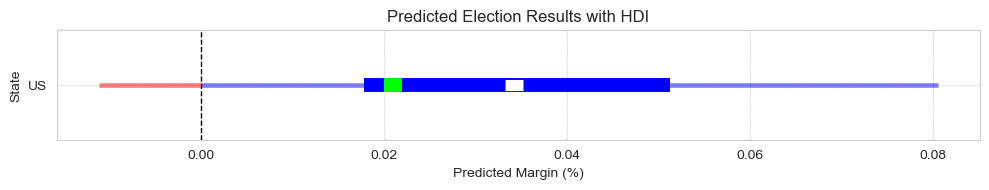

In [66]:
chart_df = df_margin.query("state_code == 'US'").sort_values(by='hdi_mean')
scale_factor = 1

cumulative_votes = np.cumsum(chart_df['scale'] * scale_factor)
y_positions = cumulative_votes - (chart_df['scale'] * scale_factor / 2)

plt.figure(figsize=(10, 2))

for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.001, xmax=row['hdi_mean']+.001, color='white', alpha=1, linewidth=row['scale'] * scale_factor*.8, zorder=5)
    plt.hlines(y=y_positions[i], xmin=row['margin']-.001, xmax=row['margin']+.001, color='lime', alpha=1, linewidth=row['scale'] * scale_factor, zorder=5)
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['scale'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['scale'] * scale_factor, zorder=3)
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

plt.yticks(y_positions, chart_df['state_code'])

plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

plt.savefig(f'../Results/{year}_president/hdi_us.png')

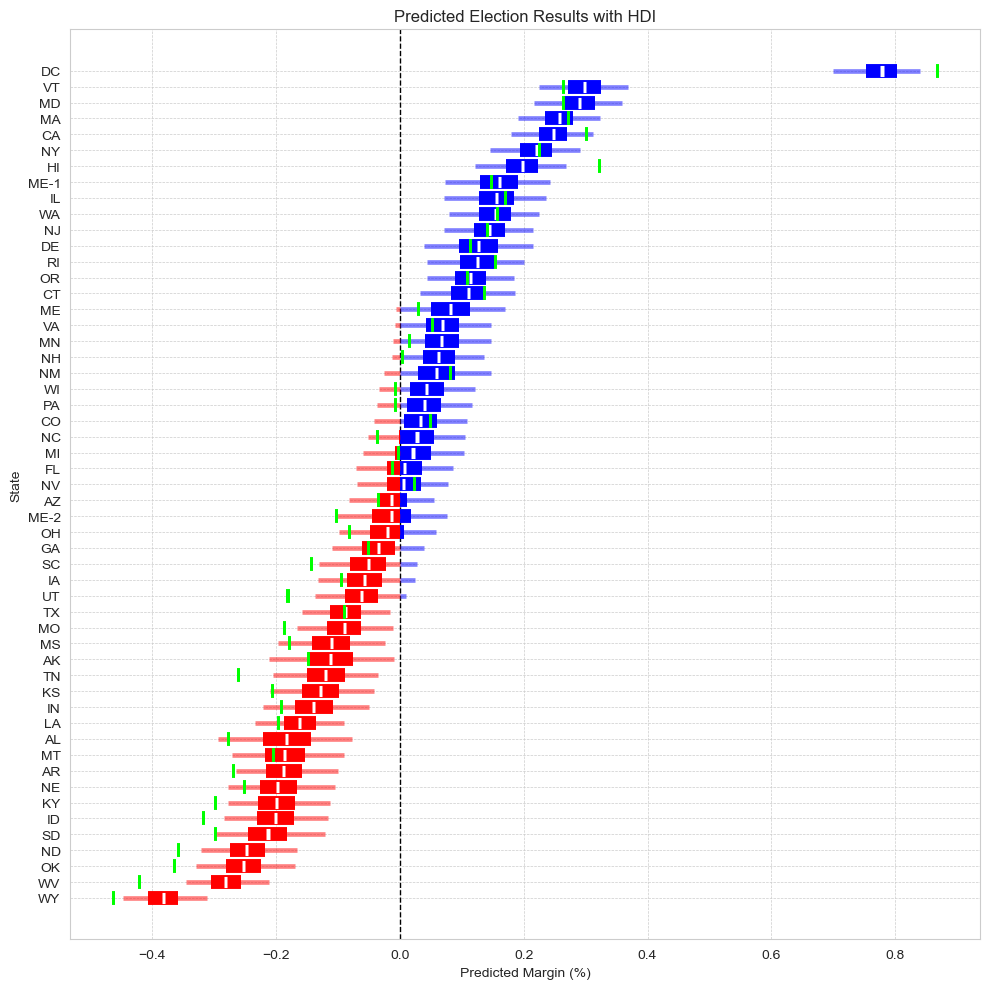

In [67]:
chart_df = df_margin.query("state_code != 'US'").sort_values(by='hdi_mean')
scale_factor = 1

cumulative_votes = np.cumsum(chart_df['scale'] * scale_factor)
y_positions = cumulative_votes - (chart_df['scale'] * scale_factor / 2)

plt.figure(figsize=(10, 10))

for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.0025, xmax=row['hdi_mean']+.0025, color='white', alpha=1, linewidth=row['scale'] * scale_factor*.8, zorder=5)
    plt.hlines(y=y_positions[i], xmin=row['margin']-.0025, xmax=row['margin']+.0025, color='lime', alpha=1, linewidth=row['scale'] * scale_factor, zorder=5)
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['scale'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['scale'] * scale_factor, zorder=3)
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

plt.yticks(y_positions, chart_df['state_code'])

plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

plt.savefig(f'../Results/{year}_president/hdi_all.png')

In [68]:
df_margin['error'] =  df_margin.hdi_mean - df_margin.margin

df_margin = pd.merge(df_margin, pd.DataFrame(df.state.value_counts()),
         how="left",
         left_on='state_code',
         right_index=True)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/2100134960.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/2100134960.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/2100134960.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

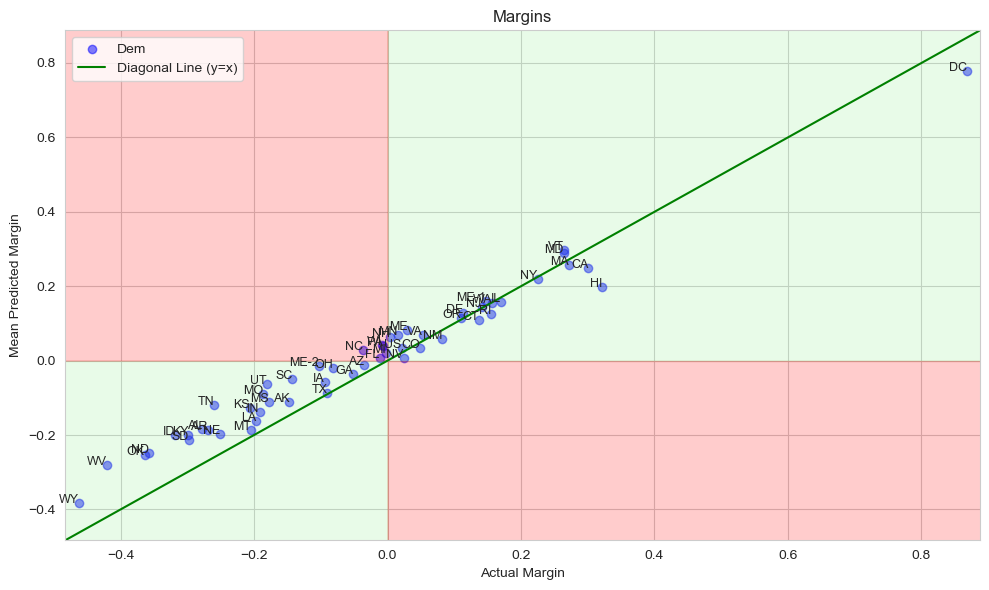

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

import statsmodels.api as sm
import scipy.stats as stats

X = df_margin['margin']
y = df_margin['hdi_mean']
weights = df_margin['count']

X = sm.add_constant(X)

wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

slope = results.params[1]
intercept = results.params[0]

x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals

plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

ax.set_xlim(df_margin[['margin','hdi_mean']].min().min()-.02, df_margin[['margin','hdi_mean']].max().max()+.02)
ax.set_ylim(df_margin[['margin','hdi_mean']].min().min()-.02, df_margin[['margin','hdi_mean']].max().max()+.02)

ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

plt.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/margins.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/3371754012.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_val = df_margin['margin'][i]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/3371754012.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val = df_margin['hdi_mean'][i]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/3371754012.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

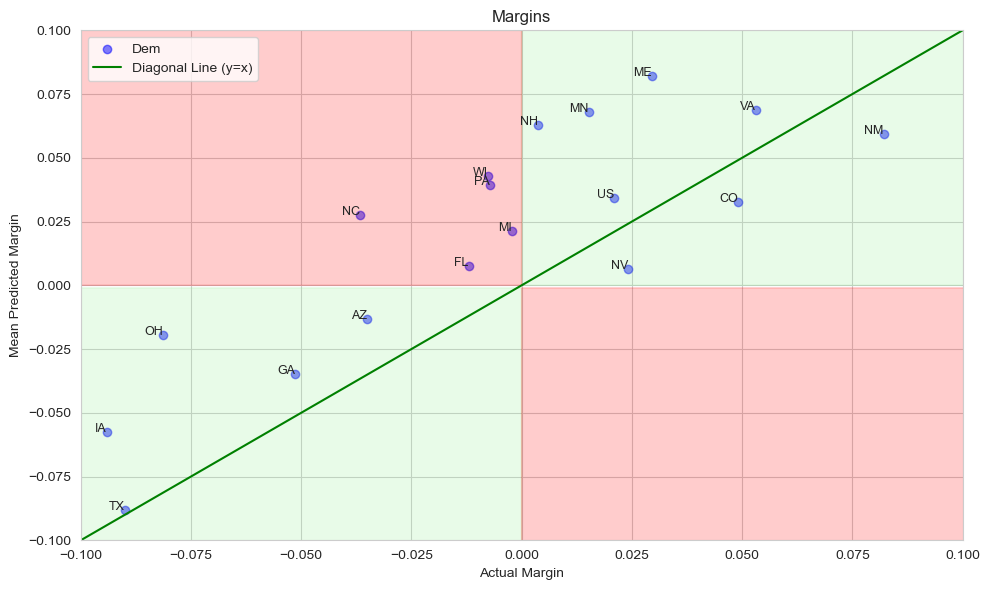

In [70]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals

plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

ax.set_xlim(-.1, .1)
ax.set_ylim(-.1, .1)

ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

plt.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/margins_zoom.png')

In [71]:
calc_slope = 1/slope
calc_intercept = intercept

In [72]:
calc_slope

1.2637914942328516

In [73]:
calc_intercept

0.027292798842447966

In [74]:
df_margin['mean_corrected'] = df_margin.hdi_mean*calc_slope-calc_intercept
df_margin['error_corrected'] =  df_margin.mean_corrected - df_margin.margin

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/1236335707.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/1236335707.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/1236335707.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

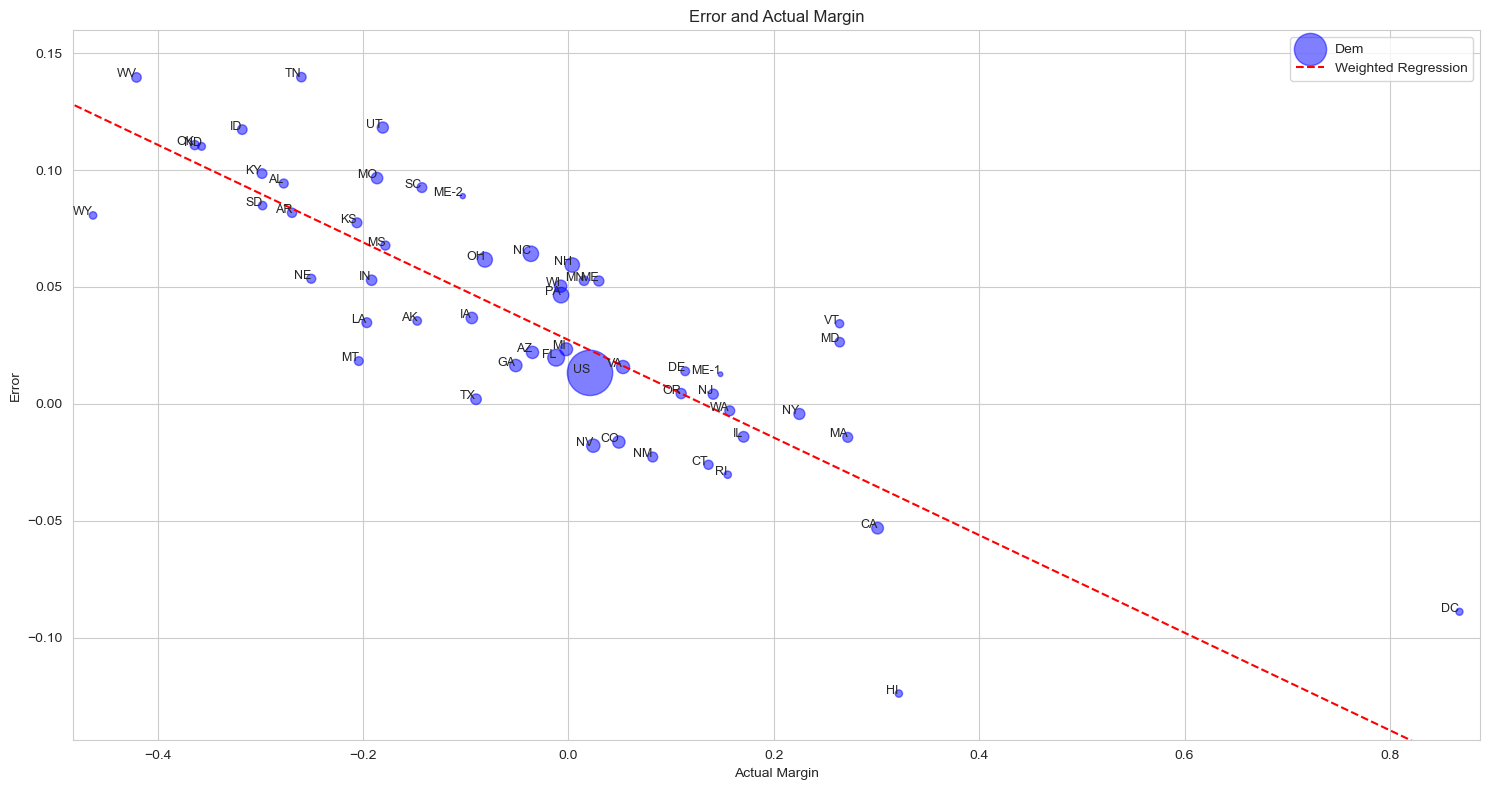

In [75]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.scatter(df_margin['margin'], df_margin['error'], 
             s=df_margin['count'], color='blue', alpha=0.5, label='Dem')

X = df_margin['margin']
y = df_margin['error']
weights = df_margin['count']

X = sm.add_constant(X)

wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

slope = results.params[1]
intercept = results.params[0]

x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

ax.set_xlim(df_margin['margin'].min()-.02, df_margin['margin'].max()+.02)
ax.set_ylim(df_margin['error'].min()-.02, df_margin['error'].max()+.02)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):
        plt.text(df_margin['margin'][i], df_margin['error'][i], state, fontsize=9, ha='right')

plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

plt.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/error.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/4277828861.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/4277828861.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_42029/4277828861.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

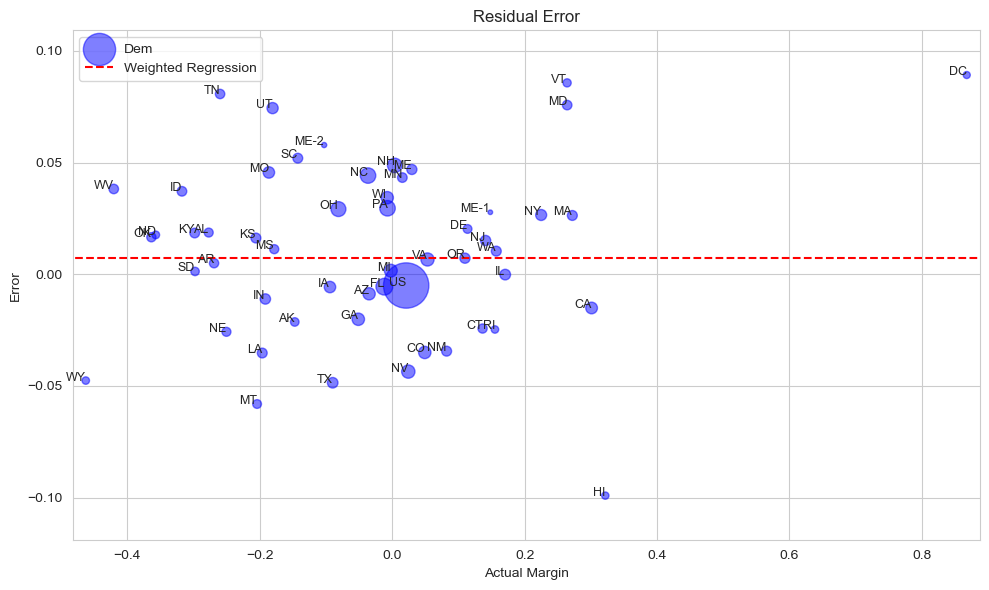

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(df_margin['margin'], df_margin['error_corrected'], 
             s=df_margin['count'], color='blue', alpha=0.5, label='Dem')

X = df_margin['margin']
y = df_margin['error_corrected']
weights = df_margin['count']

X = sm.add_constant(X)

wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

slope = results.params[1]
intercept = results.params[0]

x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

ax.set_xlim(df_margin['margin'].min()-.02, df_margin['margin'].max()+.02)
ax.set_ylim(df_margin['error_corrected'].min()-.02, df_margin['error_corrected'].max()+.02)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error_corrected'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):
        plt.text(df_margin['margin'][i], df_margin['error_corrected'][i], state, fontsize=9, ha='right')

plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Residual Error')

plt.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/error_corrected.png')

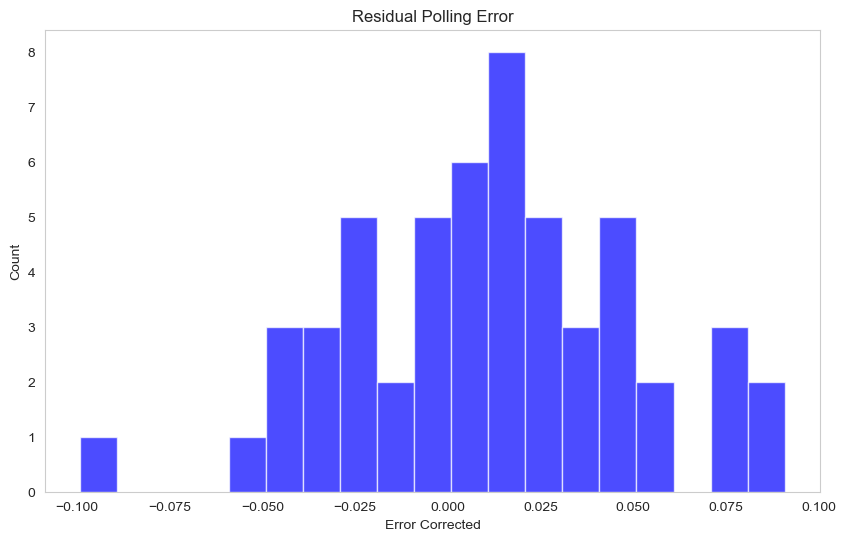

In [77]:
plt.figure(figsize=(10, 6))

bin_width = 0.01
min_edge = df_margin['error_corrected'].min()
max_edge = df_margin['error_corrected'].max()
bins = np.arange(min_edge, max_edge + bin_width, bin_width)

plt.hist(df_margin['error_corrected'], bins=bins, alpha=0.7, color='blue')

plt.xlabel('Error Corrected')
plt.ylabel('Count')
plt.title('Residual Polling Error')
plt.grid()


plt.savefig(f'../Results/{year}_president/error_hist.png')

In [78]:
df_margin['error_corrected'].std()

0.038894838310714094

In [96]:
df_swing = df_state[['state_code',f'electoral_{year}']]
df_swing = df_swing.merge(df_margin.hdi_mean,left_on='state_code', right_index=True, how='left')
df_swing.loc[df_swing['state_code'].isin(blue_states), 'hdi_mean'] = 1
df_swing.loc[df_swing['state_code'].isin(red_states), 'hdi_mean'] = -1
df_swing.loc[df_swing['state_code'].isin(['ME-1','ME-2']), 'hdi_mean'] = df_swing.loc[df_swing['state_code'].isin(['ME']), 'hdi_mean'].values[0]
df_swing = df_swing.sort_values(by='hdi_mean')
df_swing['running_sum'] = df_swing[f'electoral_{year}'].cumsum()
df_swing['swing_score'] = ((df_swing['running_sum'] - 269)**2)**.5

df_swing.loc[
    (~df_swing['state_code'].isin(['US'])) & (df_swing['swing_score'] <= 50)
].sort_values(by='swing_score')

,state_code,electoral_2016,hdi_mean,running_sum,swing_score
24,MI,16,0.021120,263,6.0
39,NC,15,0.027569,278,9.0
5,CO,9,0.032737,287,18.0
9,FL,29,0.007686,247,22.0
44,PA,20,0.039254,307,38.0
55,WI,10,0.042693,317,48.0
